# Abstract

This work aims to predict the qualification for the playoffs in the upcoming NHL season (2023-2024) based on the game features using neural network.

This work is continuation of the Midterm work which used the kNN and Decision tree algorithms for prediction.


# Introduction

The National Hockey League is a professional ice hockey league in North America consisting of 32 (as of 2023) teams: 25 in the United States and 7 in Canada. 

Eight teams from each of the two conferences qualify for the playoffs based on their total regular season points.

Thus, it is not possible to win the Stanley Cup without being qualified for playoffs. 

Making precise predictions might help coaches improve team game strategies and adjust plans before the next game.

In [64]:
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Methodology


## 4.5.1. Defining the problem and assembling a dataset

I am trying to predict whether a team is qualified for playoff or not based on historical data. 
Thus, this is binary classification problem.

The dataset was taken from the MoneyPuck [source](https://moneypuck.com/moneypuck/playerData/careers/gameByGame/all_teams.csv).

The data is free to use. No guarantees are made to the quality of the data. NHL data is known to have issues and biases. 

Data is summarized on the season level and a game-by-game level going from 2008 up to 2023. 

The data for 2022 and 2023 will be filtered out because the prediction is going to be made for the 2022-2024 seasons.
Data for seasons up to 2022 is taken from the [file](https://moneypuck.com/moneypuck/playerData/seasonSummary/2023/regular/teams.csv)

The historical data contains the column `playoffGame` a flag depicting whether a game was played during playoffs. 

Thus, if a team plays at least one game during the season’s playoff it means that the team has been qualified for the playoff.
Based on `playofGame` I calculate the value of `playoff_qualified`.

In [65]:
def read_nhl_data():
    _nhl_data = pd.read_csv('moneypack/all_teams.csv')
    _nhl_data = _nhl_data.dropna()

    columns_to_drop = [
        'name', 'gameId', 'playerTeam',
        'opposingTeam', 'home_or_away',
        'gameDate', 'position',
        'situation', 'iceTime',
        #'playoffGame'
    ]

    _nhl_data = _nhl_data.sort_values(by=['team', 'season'])
    _nhl_data = _nhl_data.drop(columns=columns_to_drop)
    _nhl_data = _nhl_data.groupby(['team', 'season'], as_index=False).mean()
    _nhl_data['playoff_qualified'] = _nhl_data['playoffGame'].apply(lambda val: 1 if val > 0 else 0)
    _nhl_data = _nhl_data.drop(columns=['playoffGame'])

    return _nhl_data


def read_nhl_data_2023():
    _nhl_data_2023 = pd.read_csv('moneypack/teams_2023.csv')
    columns_to_drop_from_2023 = ['name', 'position', 'situation', 'iceTime', 'team.1', 'games_played']

    _nhl_data_2023 = _nhl_data_2023.dropna()
    _nhl_data_2023 = _nhl_data_2023.drop(columns=columns_to_drop_from_2023)
    _nhl_data_2023 = _nhl_data_2023.sort_values(by=['team', 'season'])
    _nhl_data_2023 = _nhl_data_2023.groupby(['team', 'season']).mean()
    return _nhl_data_2023


def get_team_names(_team_data):
    duplicates = pd.DataFrame(_team_data['team']).drop_duplicates(subset=None, keep='first', inplace=False,
                                                                  ignore_index=False)
    duplicates = duplicates.sort_values(by=['team'])
    return duplicates['team'].values

In [66]:
by_team_season_all = read_nhl_data()
by_team_season_all = by_team_season_all[(by_team_season_all['season'] != 2023)]
by_team_season_all = by_team_season_all[(by_team_season_all['season'] != 2022)]

seasons_data_all = by_team_season_all.drop(columns=['playoff_qualified', 'season', 'team'])
seasons_target_all = by_team_season_all['playoff_qualified'].values

## 4.5.2. Choosing a measure of success
To select the main metrics for success for the binary classification problem we need to understand if the classes are approximately equal.
Let's visualize the classes and calculate the imbalance ratio as follows

Class Counts: 1    232
0    194
Name: count, dtype: int64
Class Proportions: 1    0.544601
0    0.455399
Name: proportion, dtype: float64
Imbalance Ratio: 0.8362068965517241


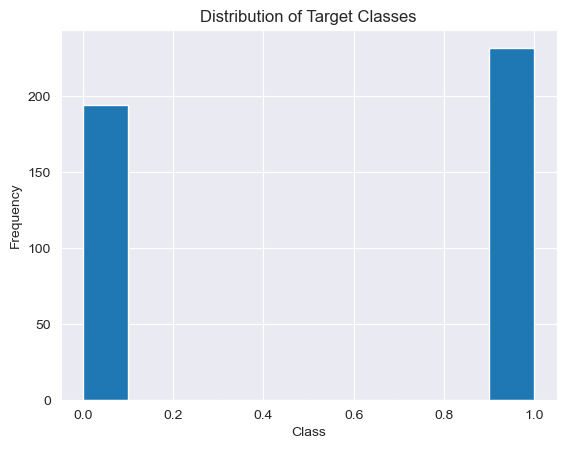

In [67]:
class_counts = pd.Series(seasons_target_all).value_counts()
class_proportions = pd.Series(seasons_target_all).value_counts(normalize=True)
imbalance_ratio = class_counts[0] / class_counts[1]  # Assuming binary classification
print("Class Counts:", class_counts)
print("Class Proportions:", class_proportions)
print("Imbalance Ratio:", imbalance_ratio)
plt.hist(seasons_target_all)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Target Classes')
plt.show()

Classes are almost balanced and the Accuracy can be used as the main metrics for success. 

## 4.5.3. Deciding on an evaluation protocol
Even though I don't have plenty of data, I maintain a hold-out validation set for the simple model.
For the advanced model, I am doing iterated K-fold validation to perform highly accurate model evaluation when little data is available

## 4.5.4. Preparing your data
In my case I have numeric data which should be formatted as tensors.

Data for 2022 is validation set

In [68]:
by_team_season_all = read_nhl_data()
by_team_season_all = by_team_season_all[(by_team_season_all['season'] == 2022)]

seasons_teams_2022 = get_team_names(by_team_season_all)
seasons_data_2022 = by_team_season_all.drop(columns=['playoff_qualified', 'season', 'team'])
seasons_target_2022 = by_team_season_all['playoff_qualified'].values

And data for 2023 is the set for actual prediction

In [69]:
seasons_data_2023 = read_nhl_data_2023()
seasons_teams_2023 = get_team_names(pd.read_csv('moneypack/teams_2023.csv'))
seasons_target_2023 = [0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
                       0]  #<40
# I took it from Moneypuck's March prediction
seasons_target_2023_march = [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
                             0, 0]

The values taken by these tensors should be scaled to small values: for example, in the [-1, 1] range or [0, 1] range.
So I have to transform features by scaling each feature to a given range.
This `MinMaxScaler` estimator scales and translates each feature individually such that it is in the given range on the training set, between zero and one.

In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
seasons_data_all = scaler.fit_transform(seasons_data_all)
seasons_data_2022 = scaler.fit_transform(seasons_data_2022)
seasons_data_2023 = scaler.fit_transform(seasons_data_2023)
print(seasons_data_2022)

[[0.         0.05098676 0.05835644 ... 0.98334063 1.         1.        ]
 [0.13453518 0.         0.         ... 1.         0.99729324 0.97581056]
 [0.85038411 0.71967475 0.70747693 ... 0.29028081 0.26721015 0.26381488]
 ...
 [0.63753181 0.32678133 0.4863255  ... 0.23511574 0.22135281 0.23107669]
 [0.64870309 0.51797002 0.55173883 ... 0.36275068 0.35802139 0.35461815]
 [0.54873341 0.53459687 0.5518523  ... 0.52671626 0.52122417 0.52591267]]


## 4.5.5. Developing a model that does better than a baseline
At this stage I need to achieve statistical power, i.e, to develop a small model that is capable of beating a dumb baseline.
Let's define the dumb baseline model first.

In [71]:
def plot_history(title, xlabel, ylabel, plot1_label, plot1_vals, plot2_label, plot2_vals):
    plt.clf()
    epochs = range(1, len(plot1_vals) + 1)
    plt.plot(epochs, plot1_vals, 'bo', label=plot1_label)
    plt.plot(epochs, plot2_vals, 'b', label=plot2_label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

Prepare data

In [72]:
limit = 320

data = seasons_data_all
target = seasons_target_all

x_val = data[:limit]
y_val = target[:limit]
partial_x_train = data[limit:]
partial_y_train = target[limit:]


This baseline model is based on the “stratified” strategy[1]: This strategy randomly selects class labels based on the class distribution in the training set. 
It aims to maintain the same class distribution as the training data, making it useful for imbalanced classes.

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(partial_x_train, partial_y_train)
baseline_y_pred = dummy_clf.predict(seasons_data_2022)
dummy_model_accuracy = accuracy_score(seasons_target_2022, baseline_y_pred)
print(f'Random baseline model accuracy {dummy_model_accuracy}')


Random baseline model accuracy 0.46875



### Model better than baseline
Now, using simple hold-out validation, train the model for 20 epochs (20 iterations over all samples in the x_train and y_train tensors).
For a binary classification problem, it is recommended to start with the following settings
* Last-layer activation - `sigmoid` in the last layer
* Loss function - `binary_crossentropy`
* Optimization configuration - it is safe to go with `rmsprop` and its default learning rate

 The training loss indicates if the model is learning.
 The validation loss indicates if the model is able to generalise well on new data.

Epoch 1/20
4/4 [==============================] - 1s 104ms/step - loss: 0.6779 - accuracy: 0.5755 - val_loss: 0.6816 - val_accuracy: 0.5125
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 0.6311 - accuracy: 0.6698 - val_loss: 0.6442 - val_accuracy: 0.6781
Epoch 3/20
4/4 [==============================] - 0s 25ms/step - loss: 0.6136 - accuracy: 0.6981 - val_loss: 0.6382 - val_accuracy: 0.6375
Epoch 4/20
4/4 [==============================] - 0s 25ms/step - loss: 0.5956 - accuracy: 0.7358 - val_loss: 0.6195 - val_accuracy: 0.6875
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: 0.5745 - accuracy: 0.7925 - val_loss: 0.6369 - val_accuracy: 0.5938
Epoch 6/20
4/4 [==============================] - 0s 25ms/step - loss: 0.5656 - accuracy: 0.7453 - val_loss: 0.5947 - val_accuracy: 0.7250
Epoch 7/20
4/4 [==============================] - 0s 28ms/step - loss: 0.5395 - accuracy: 0.7642 - val_loss: 0.6370 - val_accuracy: 0.5906
Epoch 8/20
4/4 [==========

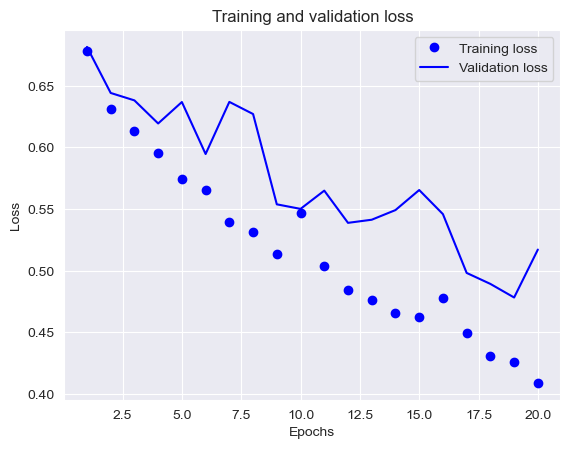

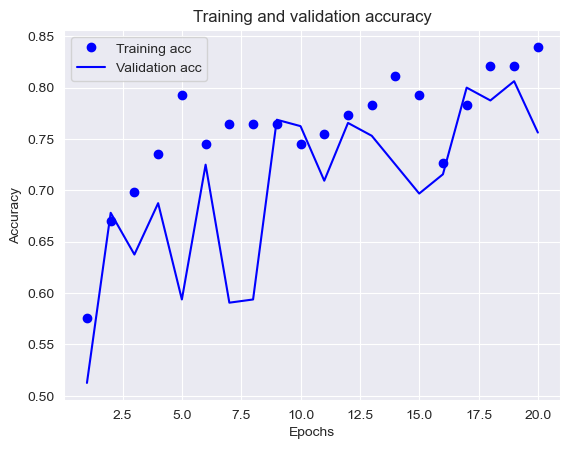

In [74]:
from keras.src.layers import Dense
from keras import Sequential

model = Sequential([
    Dense(64, activation='relu', input_shape=(seasons_data_all.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    # batch_size=256,
                    validation_data=(x_val, y_val))

history_dict = history.history
plot_history('Training and validation loss', 'Epochs', 'Loss',
             'Training loss', history_dict['loss'], 'Validation loss', history_dict['val_loss'])
plot_history('Training and validation accuracy', 'Epochs', 'Accuracy',
             'Training acc', history_dict['accuracy'], 'Validation acc', history_dict['val_accuracy'])


As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch iteration.

Evaluate the model on the data for 2022

In [75]:
simple_prediction_2022 = model.evaluate(seasons_data_2022, seasons_target_2022)
print(f'Simple model prediction accuracy is {simple_prediction_2022[1]}, loss is {simple_prediction_2022[0]}')

1/1 [==============================] - 0s 42ms/step - loss: 0.4923 - accuracy: 0.8125
Simple model prediction accuracy is 0.8125, loss is 0.4923165738582611


## 4.5.6. Scaling up: developing a model that overfits
So, to determine the model's size, let's develop a model that overfits. 
Let's add layers, make the layers bigger, and train for more epochs.

The K-fold is for situations where relatively little data is available, and you need to evaluate your model as precisely as possible.

Epoch 1/40
12/12 [==============================] - 2s 48ms/step - loss: 0.6526 - accuracy: 0.6319 - val_loss: 0.6824 - val_accuracy: 0.5814
Epoch 2/40
12/12 [==============================] - 0s 21ms/step - loss: 0.5990 - accuracy: 0.6997 - val_loss: 0.4255 - val_accuracy: 0.8837
Epoch 3/40
12/12 [==============================] - 0s 20ms/step - loss: 0.5237 - accuracy: 0.7572 - val_loss: 0.4011 - val_accuracy: 0.8837
Epoch 4/40
12/12 [==============================] - 0s 20ms/step - loss: 0.4915 - accuracy: 0.7650 - val_loss: 0.3406 - val_accuracy: 0.9070
Epoch 5/40
12/12 [==============================] - 0s 21ms/step - loss: 0.5036 - accuracy: 0.7624 - val_loss: 0.4135 - val_accuracy: 0.8140
Epoch 6/40
12/12 [==============================] - 0s 22ms/step - loss: 0.4447 - accuracy: 0.8016 - val_loss: 0.6808 - val_accuracy: 0.6744
Epoch 7/40
12/12 [==============================] - 0s 25ms/step - loss: 0.4398 - accuracy: 0.7963 - val_loss: 0.6986 - val_accuracy: 0.6977
Epoch 8/40
12

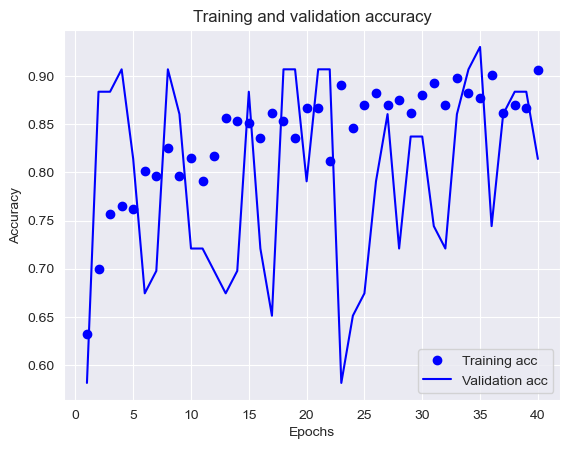

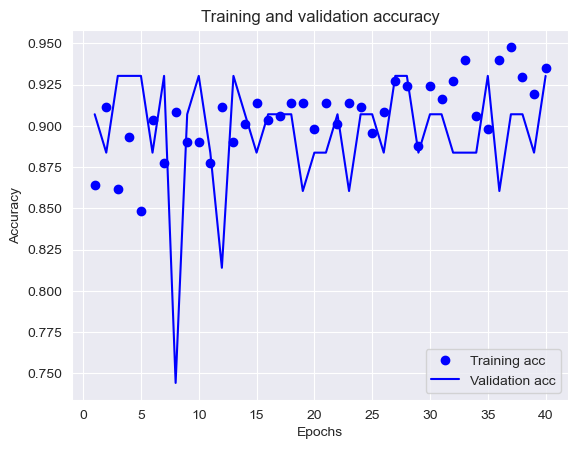

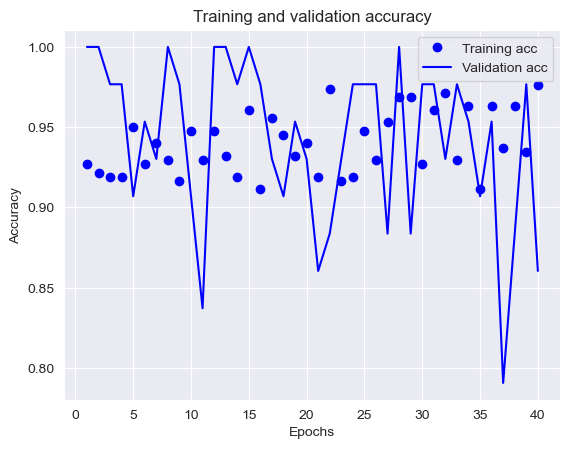

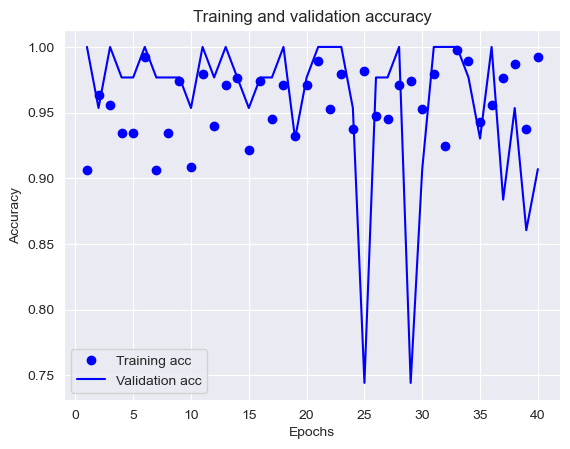

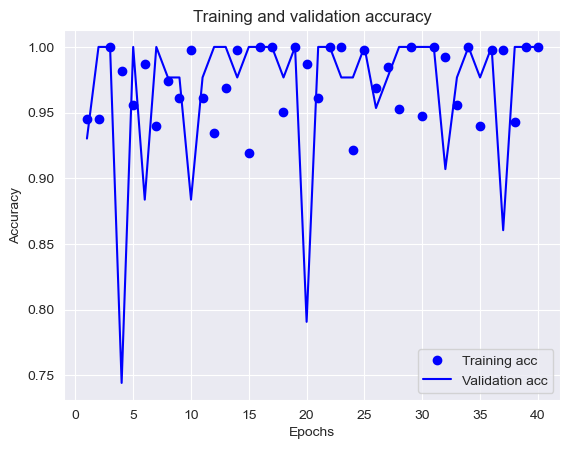

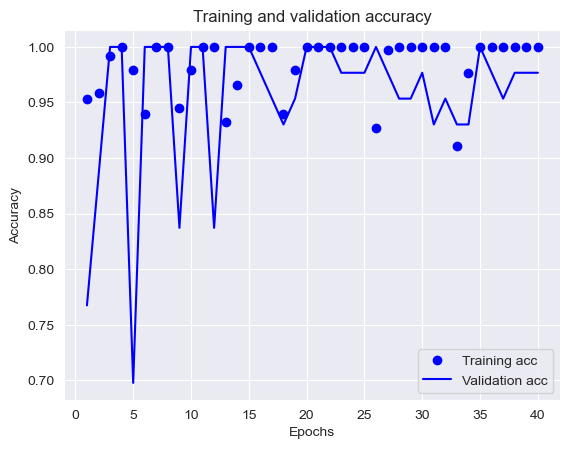

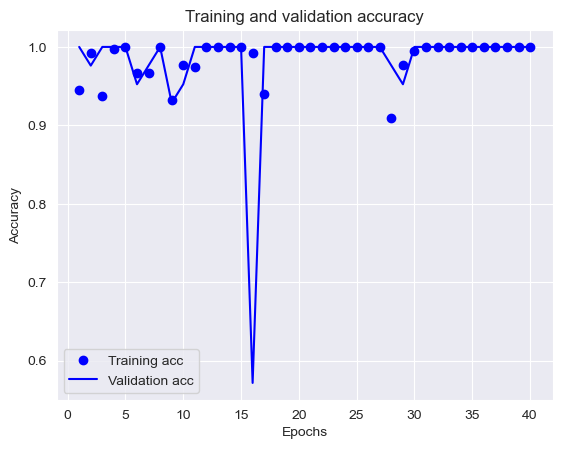

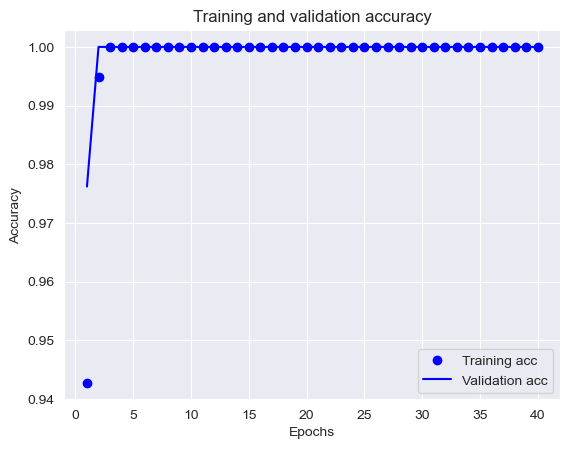

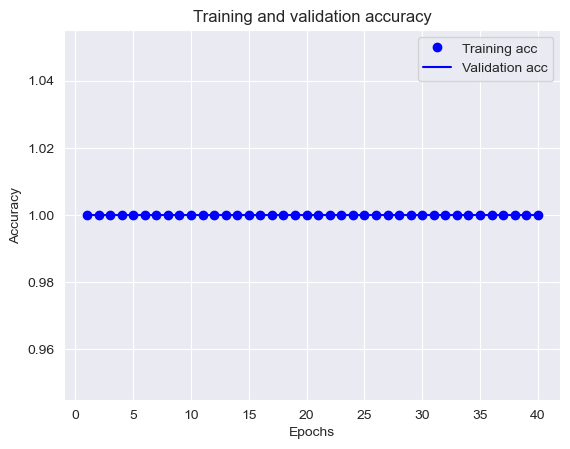

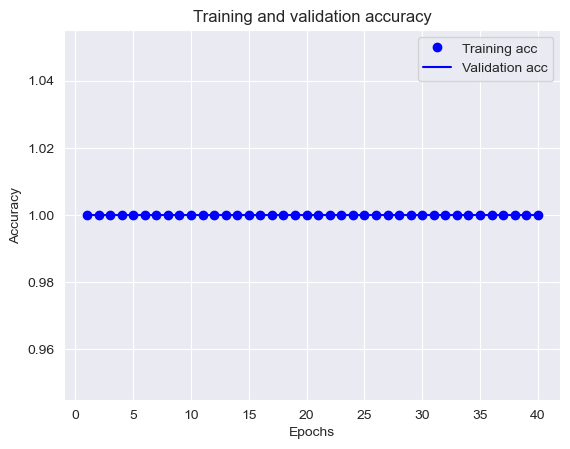

1/1 [==============================] - 0s 54ms/step - loss: 0.7304 - accuracy: 0.8750
Advanced model prediction accuracy is 0.875, loss is 0.7304273247718811


In [76]:
from sklearn.model_selection import StratifiedKFold

k = 10
advanced_epochs = 40
advanced_batch_size = 32
scores = []

advanced_model = Sequential([
    Dense(512, activation='relu', input_shape=(seasons_data_all.shape[1],)),
    Dense(256, activation='relu', ),
    Dense(128, activation='relu', ),
    Dense(64, activation='relu', ),
    Dense(32, activation='relu', ),
    Dense(1, activation='sigmoid')
])

advanced_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for train_idx, val_idx in kfold.split(data, target):
    X_train_fold, X_val_fold = data[train_idx], data[val_idx]
    y_train_fold, y_val_fold = target[train_idx], target[val_idx]
    scores.append(advanced_model.fit(X_train_fold,
                                     y_train_fold,
                                     epochs=advanced_epochs,
                                     batch_size=advanced_batch_size,
                                     validation_data=(X_val_fold, y_val_fold)))

for hist in scores:
    hist_dict = hist.history
    plot_history('Training and validation accuracy', 'Epochs', 'Accuracy',
                 'Training acc', hist_dict['accuracy'], 'Validation acc', hist_dict['val_accuracy'])

advanced_prediction_2022 = advanced_model.evaluate(seasons_data_2022, seasons_target_2022)
print(f'Advanced model prediction accuracy is {advanced_prediction_2022[1]}, loss is {advanced_prediction_2022[0]}')


## 4.5.7. Regularizing your model and tuning your hyperparameters
Let's enhance the module with dropouts and try to add and remove layers.

L1 and L2 regularization are machine learning methods that add a penalty term to the loss function. L1 regularization is also known as lasso regression, and L2 regularization is known as ridge regression.

L1 regularization adds the coefficient's absolute value as a penalty term, while L2 regularization adds the coefficient's squared magnitude as a penalty term.

Effect:
L1 regularization generates sparse solutions, which is helpful for feature selection. L2 regularization yields non-sparse solutions, which is beneficial for building simpler models.

In [77]:
from keras.src import regularizers
from keras.src.layers import Dropout
from sklearn.model_selection import StratifiedKFold
from keras import optimizers

k = 5
reg_advanced_epochs = 21
reg_advanced_batch_size = 100
regularized_scores = []
opt = optimizers.Adam(learning_rate=0.001)

regularized_advanced_model = Sequential([
    Dense(256, activation='relu', input_shape=(seasons_data_all.shape[1],), kernel_regularizer=regularizers.l1(0.001)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.01),#  accuracy drops to 0.5
    Dense(64, activation='relu'),
    # Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

regularized_advanced_model.compile(optimizer=opt,
                                   loss='binary_crossentropy',
                                   metrics=['accuracy'])

kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for train_idx, val_idx in kfold.split(data, target):
    X_train_fold, X_val_fold = data[train_idx], data[val_idx]
    y_train_fold, y_val_fold = target[train_idx], target[val_idx]
    regularized_scores.append(regularized_advanced_model.fit(X_train_fold,
                                                             y_train_fold,
                                                             epochs=reg_advanced_epochs,
                                                             batch_size=reg_advanced_batch_size,
                                                             validation_data=(X_val_fold, y_val_fold)))

most_advanced_prediction_2022 = regularized_advanced_model.evaluate(seasons_data_2022, seasons_target_2022)
print(
    f'Most advanced model prediction accuracy is {most_advanced_prediction_2022[1]}, loss is {most_advanced_prediction_2022[0]}')

Epoch 1/21
4/4 [==============================] - 3s 178ms/step - loss: 3.9950 - accuracy: 0.5294 - val_loss: 3.8088 - val_accuracy: 0.6512
Epoch 2/21
4/4 [==============================] - 0s 21ms/step - loss: 3.7464 - accuracy: 0.6088 - val_loss: 3.5689 - val_accuracy: 0.7791
Epoch 3/21
4/4 [==============================] - 0s 23ms/step - loss: 3.5118 - accuracy: 0.7559 - val_loss: 3.3277 - val_accuracy: 0.8140
Epoch 4/21
4/4 [==============================] - 0s 21ms/step - loss: 3.2853 - accuracy: 0.7471 - val_loss: 3.0931 - val_accuracy: 0.7907
Epoch 5/21
4/4 [==============================] - 0s 21ms/step - loss: 3.0620 - accuracy: 0.7529 - val_loss: 2.8771 - val_accuracy: 0.7791
Epoch 6/21
4/4 [==============================] - 0s 23ms/step - loss: 2.8770 - accuracy: 0.7647 - val_loss: 2.7957 - val_accuracy: 0.7326
Epoch 7/21
4/4 [==============================] - 0s 26ms/step - loss: 2.7467 - accuracy: 0.7618 - val_loss: 2.5449 - val_accuracy: 0.8372
Epoch 8/21
4/4 [==========

# Results
MoneyPuck has a prediction [page](https://moneypuck.com/predictions.htm). 
They calculate odds, so I created my target vector based on those odds. 
A team gets ‘1’ if the odds are greater than 40%. 
I used this vector to see the performance of my model

In [78]:
advanced_prediction_2023 = regularized_advanced_model.predict(seasons_data_2023).flatten()
round_advanced_prediction_2023 = np.where(advanced_prediction_2023 >= 0.8, 1, 0)
final_prediction_2023 = pd.DataFrame(
    {"team": seasons_teams_2022,
     "playoff qualified": round_advanced_prediction_2023,
     "MoneyPack in Jan": seasons_target_2023,
     "MoneyPuck in March" : seasons_target_2023_march
     }
)
print(f'Prediction for season 2023-2024\n{final_prediction_2023}')


against_money_puck_prediction_2023 = regularized_advanced_model.evaluate(seasons_data_2023,
                                                                         np.array(seasons_target_2023))
print(
    f'Prediction comparing to MoneyPuck (Jan 2024 with January data) accuracy is {against_money_puck_prediction_2023[1]}, loss is {against_money_puck_prediction_2023[0]}')

against_money_puck_prediction_2023_march = regularized_advanced_model.evaluate(seasons_data_2023,
                                                                               np.array(seasons_target_2023_march))
print(
    f'Prediction comparing to MoneyPuck (Mar 2024 but the same January data) accuracy is {against_money_puck_prediction_2023_march[1]}, loss is {against_money_puck_prediction_2023_march[0]}')



1/1 [==============================] - 0s 304ms/step
Prediction for season 2023-2024
   team  playoff qualified  MoneyPack in Jan  MoneyPuck in March
0   ANA                  0                 0                   0
1   ARI                  1                 0                   0
2   BOS                  1                 1                   1
3   BUF                  0                 0                   0
4   CAR                  1                 1                   1
5   CBJ                  0                 0                   0
6   CGY                  1                 0                   0
7   CHI                  0                 0                   0
8   COL                  1                 1                   0
9   DAL                  1                 1                   1
10  DET                  1                 0                   1
11  EDM                  1                 1                   1
12  FLA                  1                 1                   1
13  L

# Evaluation
The quality of the Moneypuck's data contributed significantly to the success of our models, enabling them to discern meaningful patterns and relationships inherent in NHL game dynamics.

While the dataset provided a solid basis for our analyses, it's evident that having more data would further enhance the accuracy and robustness of our models. Including additional data points could 
capture a broader range of scenarios and nuances, improving the models' predictive capabilities. 

Notably, increasing the value of k beyond five and the number of epochs beyond twenty-one did not significantly improve accuracy.

Despite its simplicity, the simple model demonstrated good generalization capabilities, underscoring the importance of feature selection and model design.

# Conclusions
In this study, based on game data, I embarked on the challenging task of predicting the playoff qualification for the upcoming NHL season (2023-2024). 
Leveraging Machine Learning and Neural Networks concepts, I aimed to construct models capable of accurately forecasting playoff qualification.

In my midterm work, the k-Nearest Neighbors (kNN) algorithm and the Decision tree algorithm provided initial insights, achieving an accuracy of 0.875 and 0.84, respectively. 
While these results were promising, they set the stage for further refinement and improvement.

Seeking to enhance predictive capabilities, I developed a simple model with a notable accuracy of 0.81. 
By introducing and tuning layers, I crafted an advanced model with exceptional performance, boasting an accuracy of 0.9+. 
I successfully constructed a model that accurately forecasts playoff qualification based on Moneypuck's data. 

# References
[1: Baseline model example](https://medium.com/@preethi_prakash/understanding-baseline-models-in-machine-learning-3ed94f03d645)